### This is a project about detecting lane lines on different roads

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Firstly, we need to calibrate our camera!

In [2]:
# a simple demo showing how to find the chess corners of the checkboard picture

%matplotlib inline
filename="camera_cal/calibration2.jpg"
img=cv2.imread(filename)

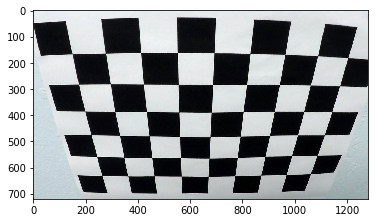

In [3]:
plt.imshow(img)

In [4]:
nx=9
ny=6
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

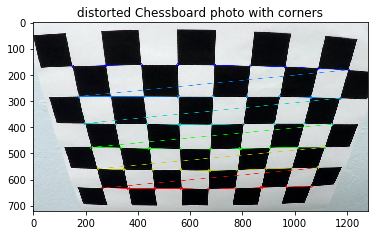

In [5]:
# draw chess corners on the picture:
if ret == True:
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.title("distorted Chessboard photo with corners")
    plt.show()

In [6]:
objp = np.zeros((nx*ny,3), np.float32)
objp.shape

(54, 3)

In [7]:
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

In [8]:
import glob
imagefiles=glob.glob('camera_cal/calibration*.jpg')

Firstly, I need to extract all the chess corners from imagefiles so that I can calibrate my cameras!

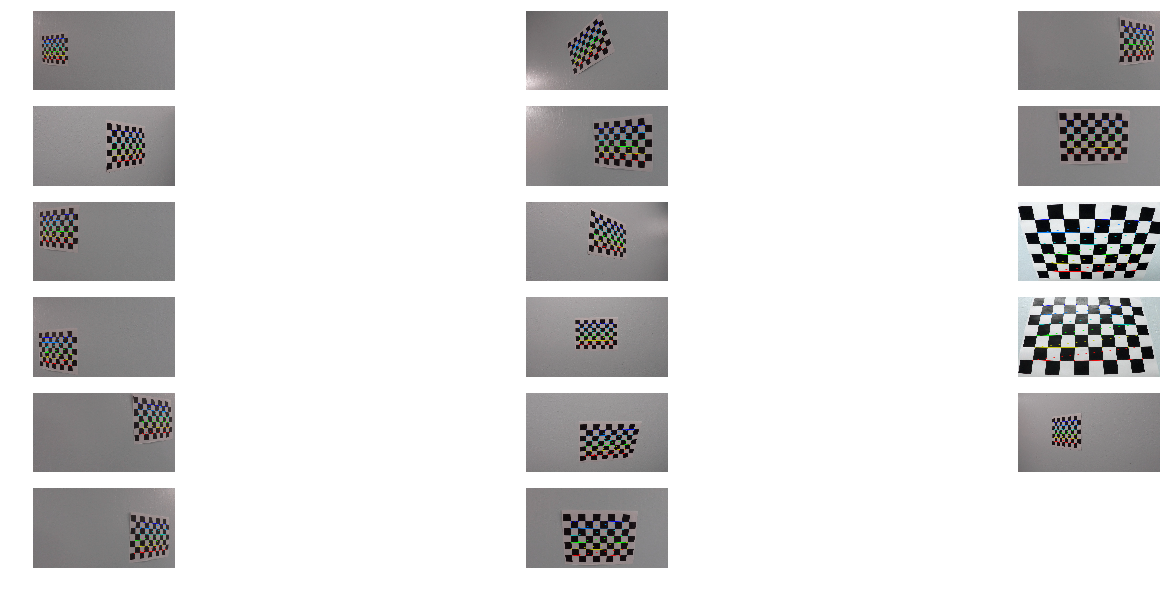

In [9]:
import pylab
pylab.rcParams['figure.figsize'] = (25, 12)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

count=1
for i in range(len(imagefiles)):
    image=cv2.imread(imagefiles[i])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret==True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        plt.subplot(7,3,count)
        count+=1
        plt.axis('off')
        plt.imshow(image)
        #plt.show()
        

Then we need to create a undistort functions to undistort my functions

In [10]:
def undistort(image):
    img = mpimg.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

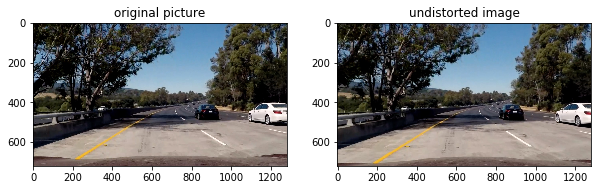

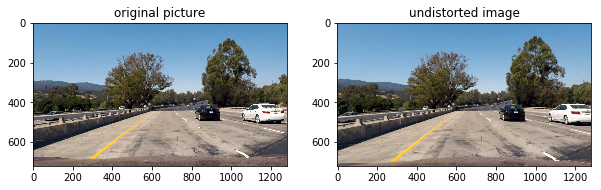

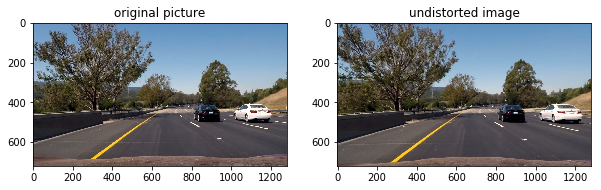

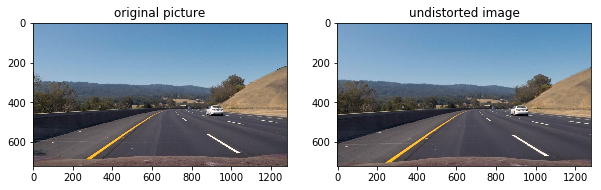

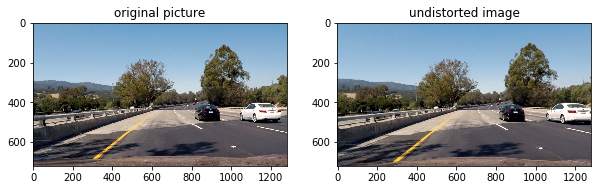

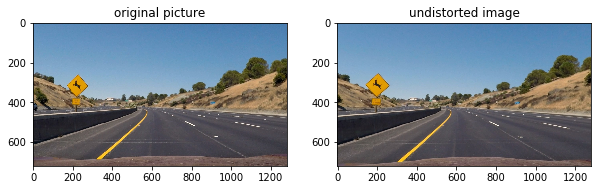

In [11]:
test_images = glob.glob('test_images/test*.jpg')
for image in test_images:
    #image=cv2.imread(imagefile)
    undistortimage=undistort(image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
    originalimage=mpimg.imread(image)
    ax1.imshow(originalimage)
    ax1.set_title("original picture")
    ax2.imshow(undistortimage)
    ax2.set_title("undistorted image")

### Perspective Transform
Next, I need to transform the pictures above into a bird view so that I can compute the exact location of the lane lines

In [12]:
def warp(img):
    undist=undistort(img)
    img_size=(undist.shape[1],undist.shape[0])
    src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped,M

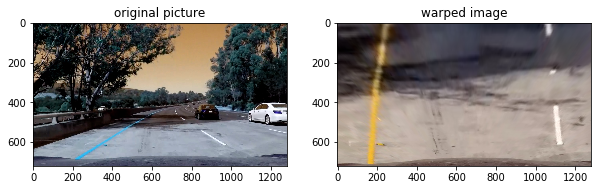

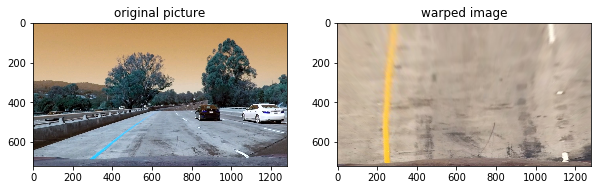

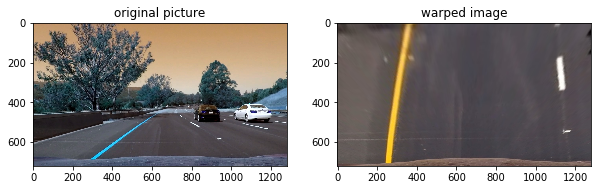

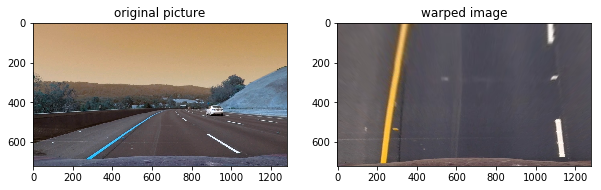

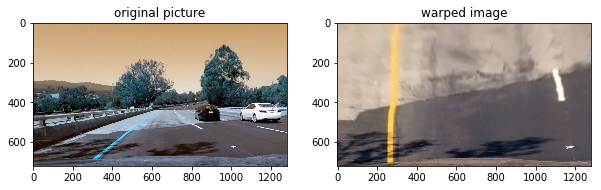

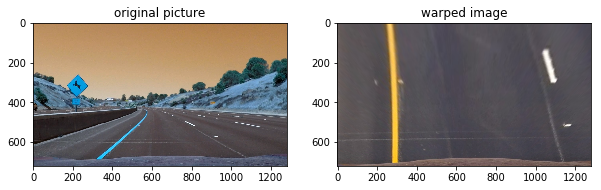

In [13]:
test_images = glob.glob('test_images/test*.jpg')
for image in test_images:
    #image=cv2.imread(imagefile)
    warp_image,M=warp(image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
    originalimage=cv2.imread(image)
    ax1.imshow(originalimage)
    ax1.set_title("original picture")
    ax2.imshow(warp_image)
    ax2.set_title("warped image")

### Then, we need to create a pipline to transform pictures into a binary-color picturs so that we can detect edges and lines

In [14]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img,M = warp(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    binary_image=np.zeros_like(s_channel)
    binary_image[(s_binary==1)|(sxbinary==1)]=1
    return binary_image,img,M
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_image = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    #return color_binary,img,M

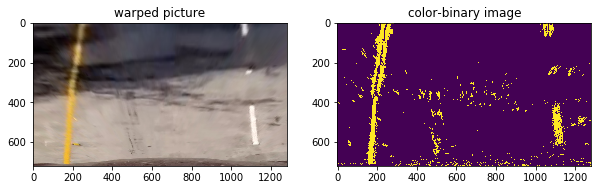

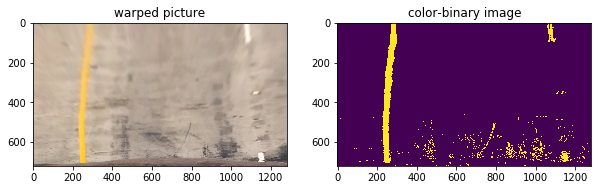

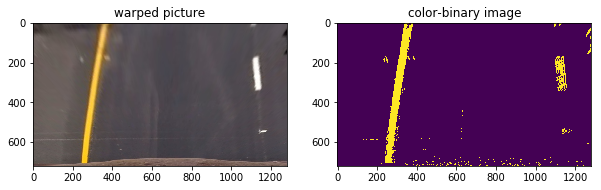

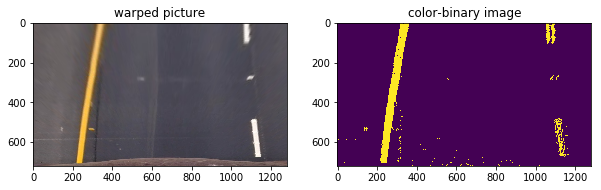

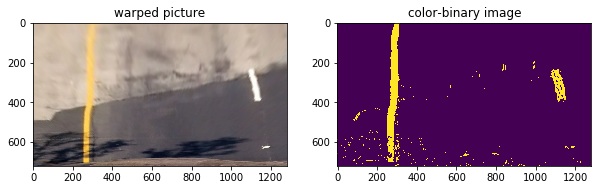

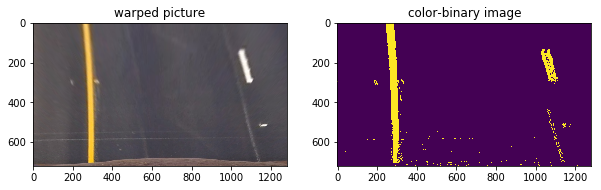

In [15]:
test_images = glob.glob('test_images/test*.jpg')
for image in test_images:
    #image=cv2.imread(imagefile)
    color_binary,warped_image,M=pipeline(image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
    ax1.imshow(warped_image)
    ax1.set_title("warped picture")
    ax2.imshow(color_binary)
    ax2.set_title("color-binary image")

### Now we need to fit a polynomial to our binary pictures 

In [20]:
def drawpoly(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    #identity non-zero positions
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
          # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)  
        
    

/home/lixx3527/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


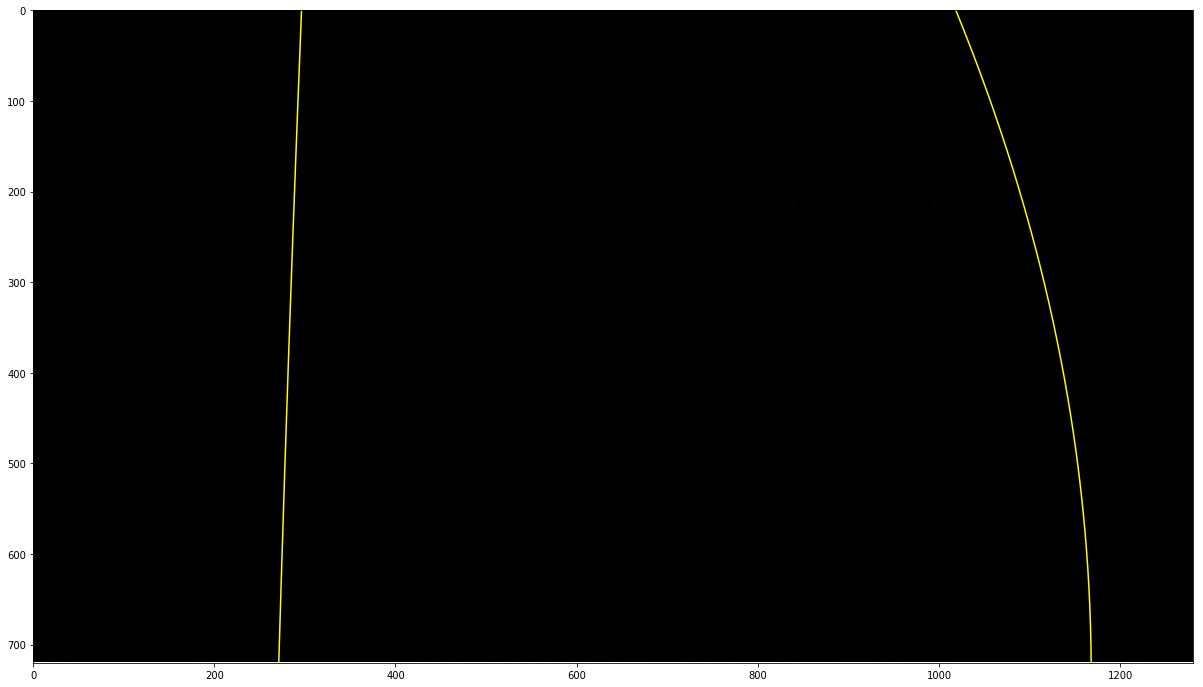

In [21]:
binary_warped,a,b=pipeline("test_images/test4.jpg")
drawpoly(binary_warped)

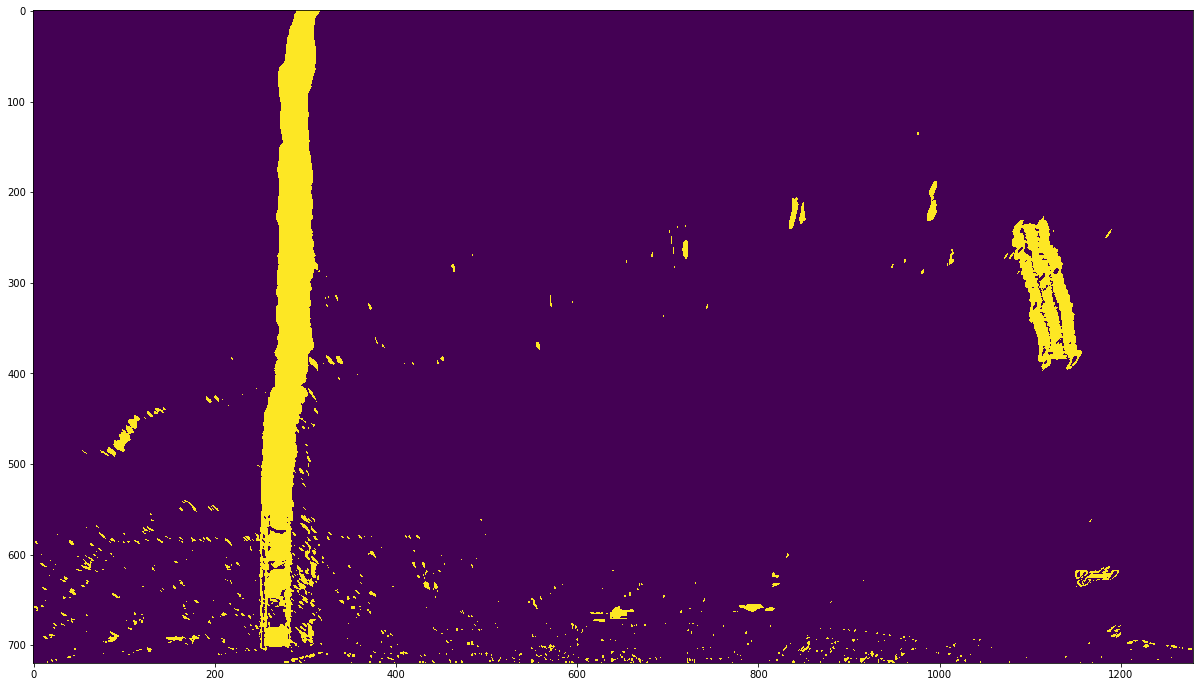

In [22]:
plt.imshow(binary_warped)

In [89]:
nonzero

(array([  0,   0,   0, ..., 719, 719, 719]),
 array([ 290,  291,  292, ..., 1077, 1155, 1169]))

In [90]:
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

In [91]:
leftx_current = leftx_base
rightx_current = rightx_base

In [93]:
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []